In [85]:

# Import packages that I need to use
%pip install wordcloud
import pandas as pd
import yfinance as yf
import re
import matplotlib.pyplot as plt
import requests
from datetime import datetime, date
from wordcloud import WordCloud
import re



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


1. How have defense stocks been affected since the beginning of the Russia-Ukraine conflict?
Source: https://pmc.ncbi.nlm.nih.gov/articles/PMC11700249/

For my first question I wanted to analyze stock prices over the course of the last several years to see trends of whos been affected the most. I wanted to do an analyses on the top performing stocks and review main reasons they've performed so well.

1. TransDigm Group




[*********************100%***********************]  144 of 144 completed


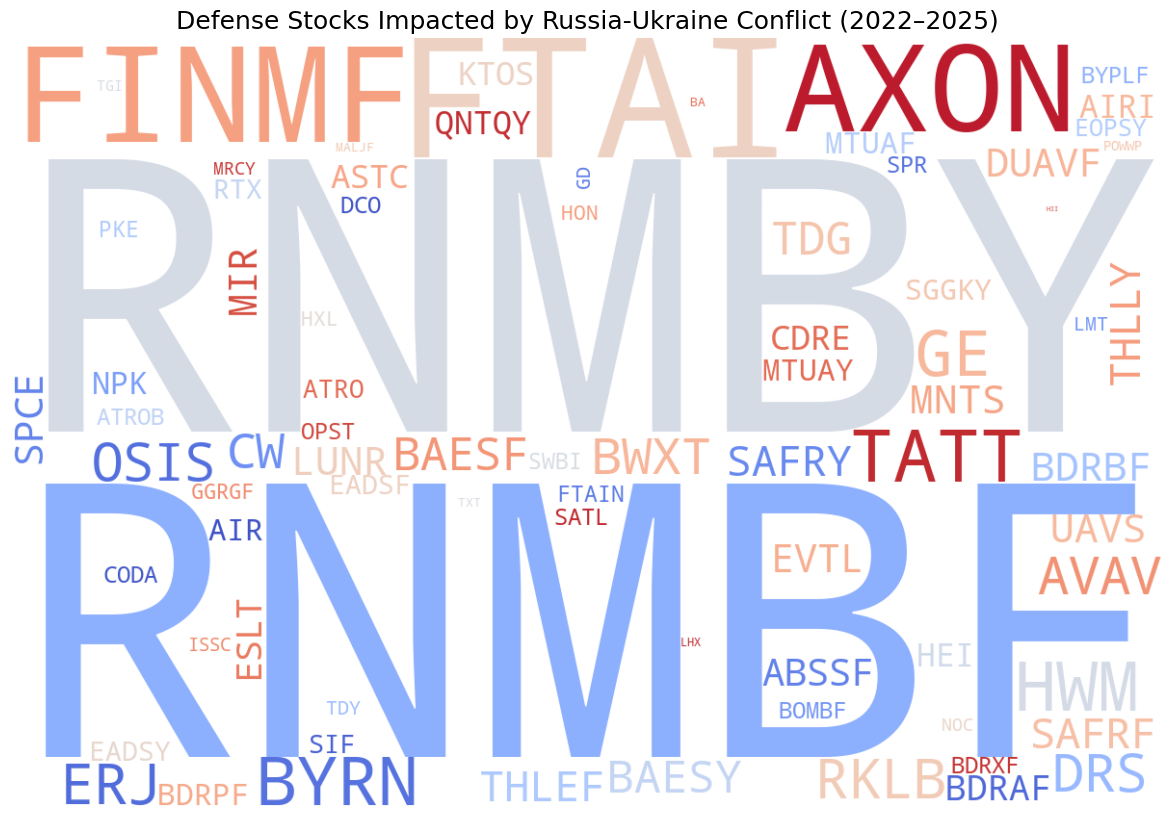

In [86]:
# Loads all defense stocks from CSV
df = pd.read_csv("./data/all-defense-stocks.csv")
symbols = df['Symbol'].values
filtered_tickers = [ticker for ticker in symbols if re.match(r'^[A-Z0-9]+$', ticker)]

# Downloads all sticker data between 2022-2025
data = yf.download(
    filtered_tickers,
    start="2022-02-20",
    end="2025-02-20"
)

# Get closing prices
prices = data["Close"].dropna(how="all")

# Filter out penny stocks (start price > $5)
start_prices = prices.iloc[0]
non_penny_stocks = start_prices[start_prices > 5].index.tolist()
filtered_prices = prices[non_penny_stocks]

# Calculates returns of each stock
returns = (filtered_prices.iloc[-1] - filtered_prices.iloc[0]) / filtered_prices.iloc[0]
returns = returns * 100  # Convert to percentage
sorted_returns = returns.sort_values(ascending=False)

# Creates the word cloud
# Use absolute return (positive values) for sizing
wordcloud_data = {ticker: abs(ret) for ticker, ret in sorted_returns.items()}

# Formats the word clouds options and add data
wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='coolwarm'
).generate_from_frequencies(wordcloud_data)

# Displays figure below with titles
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Defense Stocks Impacted by Russia-Ukraine Conflict (2022–2025)', fontsize=18)
plt.show()

Question 2:
How has the stock market performed yearly versus defense contracts?


2 Failed downloads:
['KRMN', 'IPCEF']: YFPricesMissingError('possibly delisted; no price data found  (1mo 1994-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 757400400, endDate = 1735707600")')


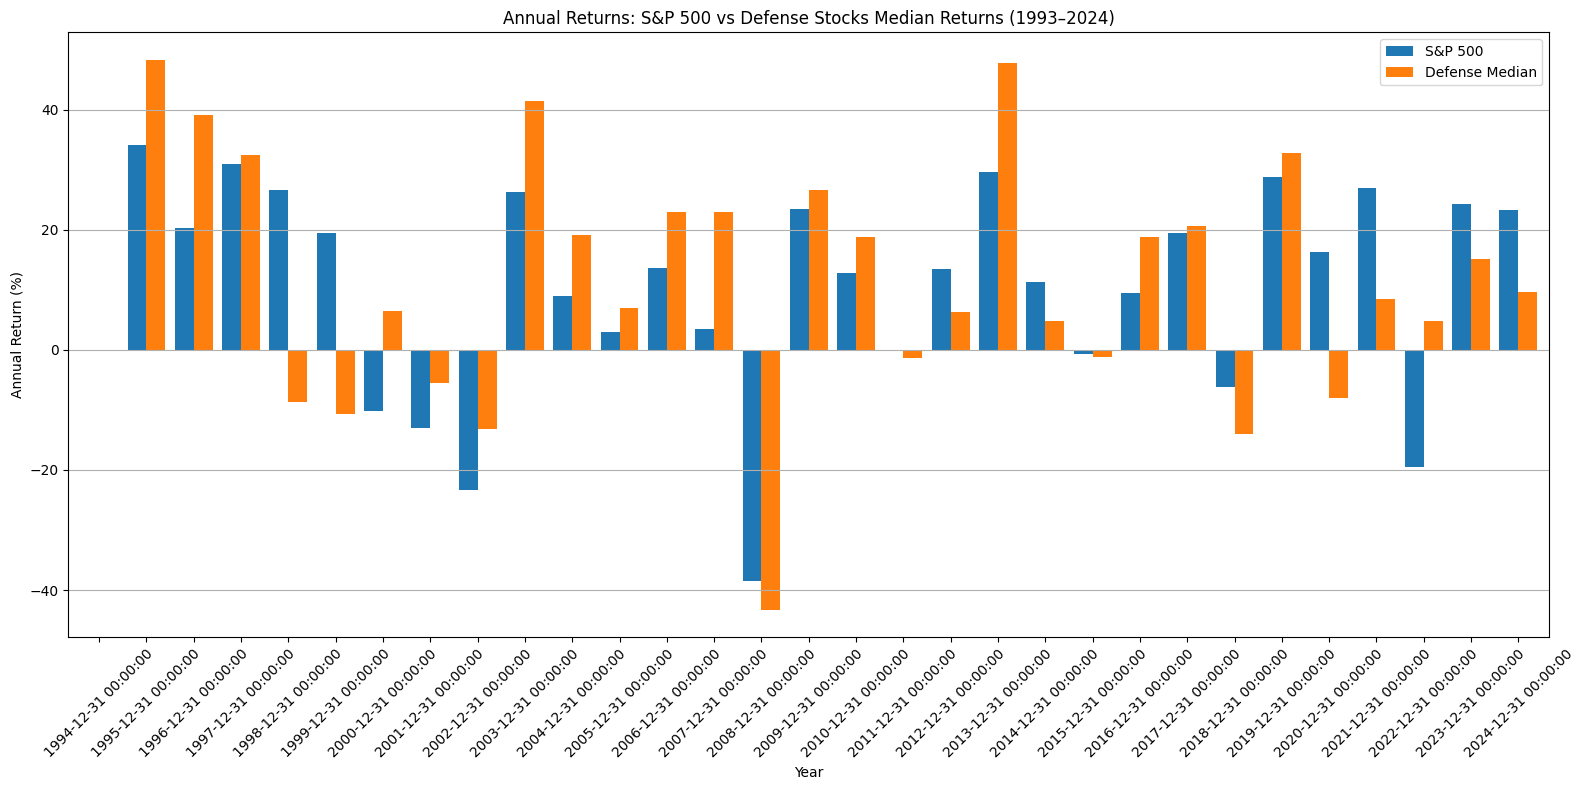

In [ ]:

# Inputs the defense stocks from a csv file
df = pd.read_csv("./data/all-defense-stocks.csv")
symbols = df['Symbol'].values
# Filters the defense stocks to readable symbols
defense_stocks = [ticker for ticker in symbols if re.match(r'^[A-Z0-9]+$', ticker)]

# Fetches the defense data based on stocks
defense_data = yf.download(
    defense_stocks,
    start="1994-01-01",
    end="2025-01-01",
    interval='1mo',
    progress=False
)

# Get annual close defense prices and calculate percentages 
defense_close = defense_data['Close']
defense_annual = defense_close.resample('YE').last()

# Remove tickets that don't appear in any year
filtered_tickers = defense_annual.dropna(axis=1).columns

# Filter to only specified tickets, then calculate returns as a percentage and then select median.
defense_annual = defense_annual[filtered_tickers]
defense_returns = defense_annual.pct_change() * 100
defense_returns_avg = defense_returns.median(axis=1)
defense_returns_avg = defense_returns_avg.squeeze()


# S&P500 ticker
sp500_ticker = "^GSPC"

# Fetch S&P500 data
sp500_data = yf.download(
    sp500_ticker,
    start="1994-01-01",
    end="2025-01-01",
    interval='1mo',
    progress=False
)

sp500_close = sp500_data['Close']

# Get close amount for S&P500, convert it to a percentage, then made sure its 1 dimensional
sp500_annual = sp500_close.resample('YE').last()
sp500_returns = sp500_annual.pct_change() * 100
sp500_returns = sp500_returns.squeeze()

matching_years = sp500_returns.index.intersection(defense_returns_avg.index)
returns_df = pd.DataFrame({
    "S&P 500": sp500_returns.loc[matching_years],
    "Defense Median": defense_returns_avg.loc[matching_years],
})

# --- Plot ---
returns_df.plot(kind='bar', figsize=(16,8), width=0.8)

plt.title("Annual Returns: S&P 500 vs Defense Stocks Median Returns (1993–2024)")
plt.ylabel("Annual Return (%)")
plt.xlabel("Year")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Question 3:
Which presidency has defense stocks performed the best?

[*********************100%***********************]  144 of 144 completed


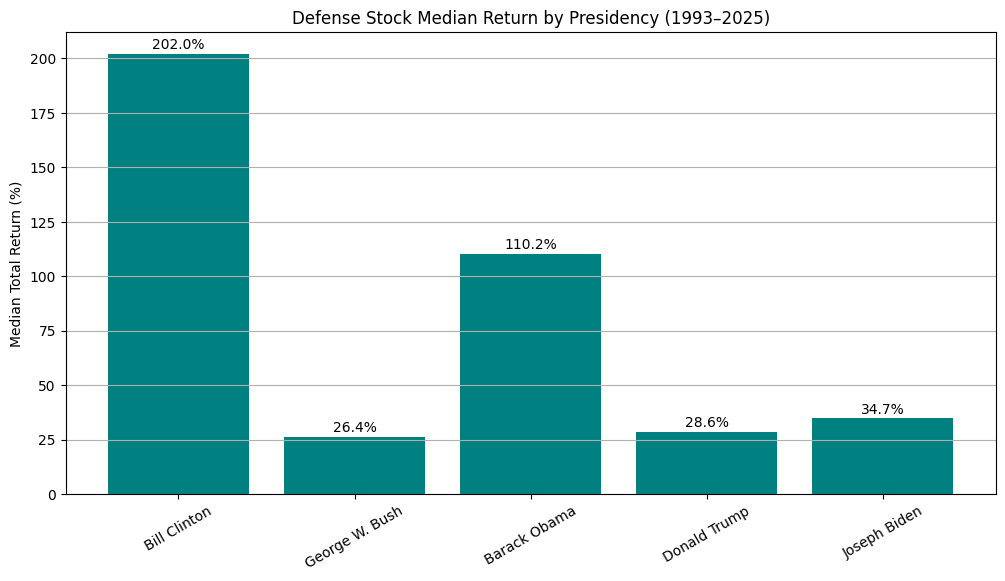

In [84]:
# Inputs the defense stocks from a csv file
df = pd.read_csv("./data/all-defense-stocks.csv")
symbols = df['Symbol'].values

# Filters the defense stocks to readable symbols
defense_stocks = [ticker for ticker in symbols if re.match(r'^[A-Z0-9]+$', ticker)]

# Download daily closing prices
data = yf.download(defense_stocks, start="1993-01-01", end="2025-04-25")["Close"]
data = data.asfreq('B').ffill()

# URL For presidents API which will help tell inform the dates
url = "https://api.sampleapis.com/presidents/presidents"
response = requests.get(url)
president_data = response.json()

# Get the most recent 5 presidents
last_five_presidents = president_data[-5:]

# Holds presidents  start and end dates
presidencies = {}

# Iterate through each president and store their approximate inaguration dates
for president in last_five_presidents:
    name = president["name"]
    start_year, end_year = president["yearsInOffice"].split("-")
    start_dt = pd.Timestamp(f"{start_year}-01-19")
    if end_year.lower() == "present":
        end_dt = pd.Timestamp(f"{str(date.today().year)}-01-18")
    else:
        end_dt = pd.Timestamp(f"{end_year}-01-18")
    presidencies[name] = (start_dt, end_dt)

# Calculates the median returns of each presidents presidency
president_returns = {}
for president, (start_date, end_date) in presidencies.items():
    pos = data.index.get_indexer([start_date], method='ffill')[0]
    start_price = data.iloc[pos]

    pos = data.index.get_indexer([end_date], method='ffill')[0]
    end_price   = data.iloc[pos]

    total_return = (end_price - start_price) / start_price
    average_total_return = total_return.median() * 100  # % return
    president_returns[president] = average_total_return

# Creates a bar plot for the presidency
plt.figure(figsize=(12,6))
bars = plt.bar(president_returns.keys(), president_returns.values(), color='teal')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%", ha='center', va='bottom')

plt.title("Defense Stock Median Return by Presidency (1993–2025)")
plt.ylabel("Median Total Return (%)")
plt.grid(axis='y')
plt.xticks(rotation=30)
plt.show()